In [107]:
import sys
import os
import importlib

parent = os.path.dirname(os.getcwd())
sys.path.insert(0, parent)

from Helpers import loadData, multiplot, sphereMask, dataSizes, chunker, unchunker, kernelPad
importlib.reload(sys.modules['Helpers.chunker'])
importlib.reload(sys.modules['Helpers.unchunker'])
importlib.reload(sys.modules['Helpers.kernelPad'])
importlib.reload(sys.modules['Helpers'])

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.fft as fft
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from skimage.feature import peak_local_max
from scipy.signal import fftconvolve

In [38]:
device = torch.cuda.get_device_name()
if device == 'NVIDIA RTX A2000 12GB':
    client = 'Desktop'
    cuts = 2
elif device == 'NVIDIA RTX 4000 Ada Generation':
    client = 'Server'
    cuts = 1

In [71]:
# Load downscaled data
folderData = os.path.join(os.path.dirname(parent),'Data')
data = loadData(location=folderData, fileName='downscale_17.hdf5')[:-1,:,:-2]

r,c,z = data.shape
print(f'Data dims: {(r,c,z)}')
if client == 'Server':
    print(f'Identified Server: {device}')
    if r % 2 == 1 and c % 2 == 1 and z % 4 == 0:
        print('Valid size')
    else:
        print('Requirements failed')
        raise TypeError
elif client == 'Desktop':
    print(f'Identified Desktop: {device}')
    if r % 2 == 1 and c % 4 == 0 and z % 4 == 0:
        print('Valid size')
    else:
        print('Requirements failed')
        raise TypeError

Data dims: (411, 512, 544)
Identified Desktop: NVIDIA RTX A2000 12GB
Valid size


In [ ]:
# Load raw 20Gb data
with h5py.File(rf'{folderData}/Scan_17.hdf5','r') as f: 
    legData = f['RawData/Scan_17'][:] # (slices, rows, width)

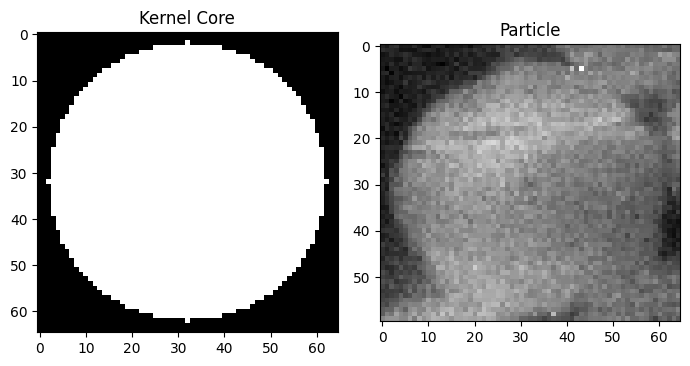

In [ ]:
# Create sphere conv mask
kernel = sphereMask(diameter=100,pad=2,scale=.6)
kP = int(kernel.shape[0]/2)+1

assert kernel.shape[0] % 2 == 1, f'Kernel must be odd: {kernel.shape}'
assert kP % 2 == 1 , f'Kernel padding must be odd: kP={kP}'

# Visualize against particle
multiplot(kernel[:,:,int(kernel.shape[2]/2)],
          data[90:150,35:100,25],
          ax_vis=True,titles=['Kernel Core','Particle'])

In [86]:
pChunks = chunker(data, kP, client)

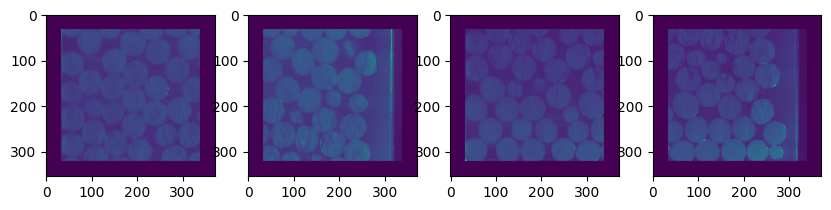

In [87]:
p=40
fig,axs = plt.subplots(1,4)
for idx,ax in enumerate(axs):
    ax.imshow(pChunks[idx][p,:,:])
fig.set_size_inches(10,5)

In [93]:
for item in pChunks:
    print(item.shape)

(477, 355, 371)
(477, 355, 371)
(477, 355, 371)
(477, 355, 371)


In [104]:
eP = [(aC-kernel.shape[idx])/2 for aC,idx in enumerate(chunk.shape)]
pKern = np.pad(kernel, pad_width=((eP[0],eP[0]),
                                  (eP[1],eP[1]),
                                  (eP[2],eP[2])))

IndexError: tuple index out of range

In [108]:
pKern = kernelPad(kernel, pChunks[0])

In [115]:
gKern = torch.from_numpy(pKern).cuda()
fgKern = fft.rfftn(gKern)
del gKern

convMaps = []
for chunk in pChunks:

    gChunk = torch.from_numpy(chunk).cuda()
    fgChunk = fft.rfftn(gChunk)
    del gChunk

    fgChunk *= fgKern
    gChunk = fft.irfftn(fgChunk, s=chunk.size())
    del fgChunk

    chunk = gChunk.cpu()
    del gChunk

    convMaps.append(chunk)

TypeError: 'int' object is not callable

In [ ]:
wholeData = unchunker(pChunks, kP, data.shape)

(411, 512, 544)
(411, 512, 544)


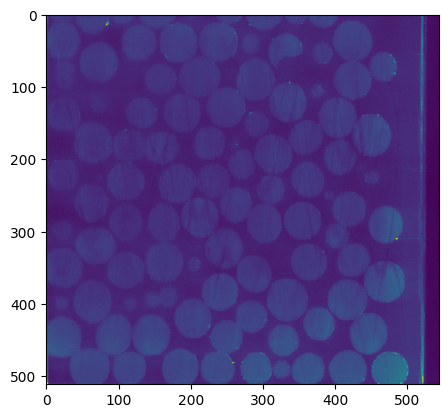

In [91]:
plt.imshow(wholeData[p,:,:])

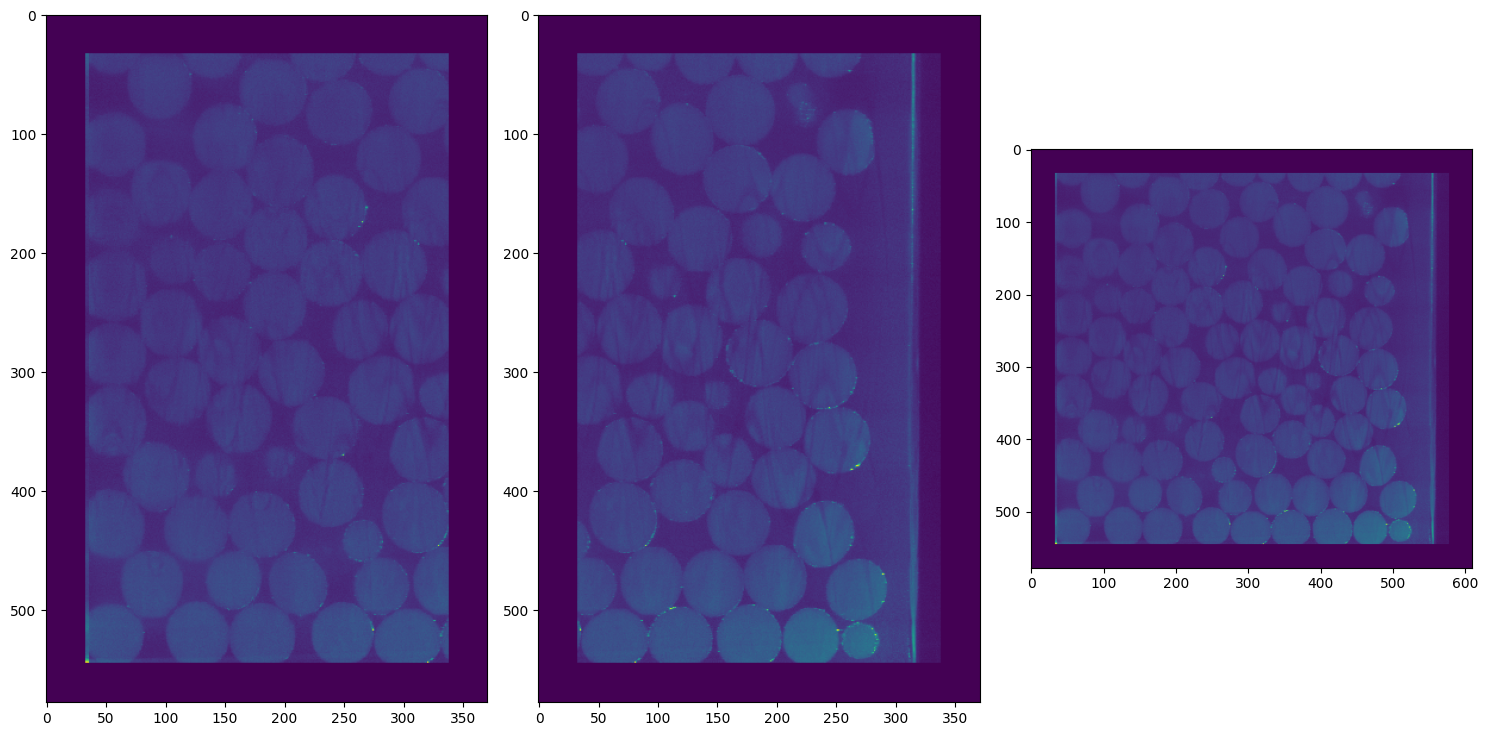

In [74]:
ll,ul,lu,uu = pChunks

fig,axs = plt.subplots(1,3)
cat = np.concatenate((ll[:,:int(c/2),:],lu[:,kP:,:]),axis=1)
axs[0].imshow(cat[p,:,:])

dog = np.concatenate((ul[:,:int(c/2),:],uu[:,kP:,:]),axis=1)
axs[1].imshow(dog[p,:,:])

dogcat = np.concatenate((cat[:,:,:int(z/2)],dog[:,:,kP:]),axis=2)
axs[2].imshow(dogcat[p,:,:])

fig.set_size_inches(15,10)
fig.tight_layout()

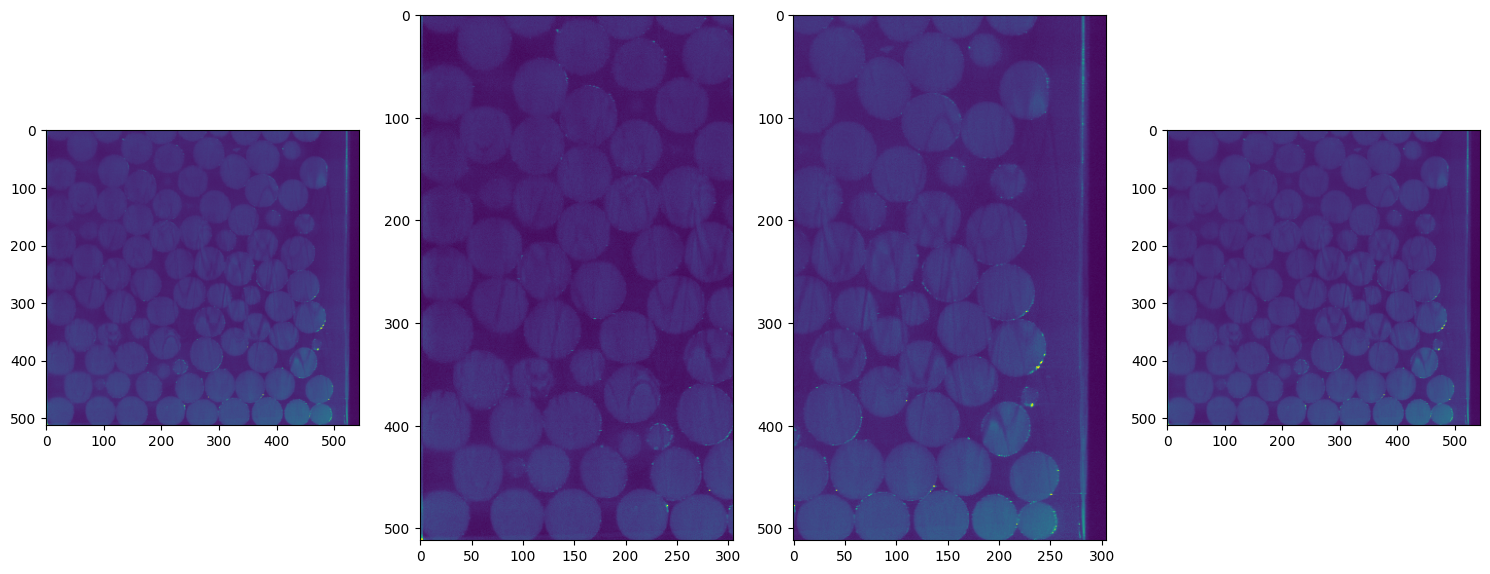

In [27]:
fig,axs = plt.subplots(1,4)
axs[0].imshow(data[p,:,:])

ll,lu = lower[:, :int(c/2)+kP ,:], lower[:, int(c/2)-kP: ,:]
cat = np.concatenate((ll[:,:int(c/2),:],lu[:,kP:,:]),axis=1)
axs[1].imshow(cat[p,:,:])

ul,uu = upper[:, :int(c/2)+kP ,:], upper[:, int(c/2)-kP: ,:]
dog = np.concatenate((ul[:,:int(c/2),:],uu[:,kP:,:]),axis=1)
axs[2].imshow(dog[p,:,:])

dogcat = np.concatenate((cat[:,:,:int(z/2)],dog[:,:,kP:]),axis=2)
axs[3].imshow(dogcat[p,:,:])

fig.set_size_inches(15,10)
fig.tight_layout()

In [29]:
pchunks = [ulP,uuP,
           llP,luP]
for chunk in pchunks:
    print(chunk.shape)
print(kernel.shape)
print(data.shape)

(477, 355, 371)
(477, 355, 371)
(477, 355, 371)
(477, 355, 371)
(65, 65, 65)
(411, 512, 544)


In [30]:
print(data.shape)

(411, 512, 544)


In [34]:
rC,cC,zC = pchunks[0].shape
rK,cK,zK = kernel.shape

pR = int((rC-rK)/2)
pKern = np.pad(kernel,pad_width=((pR+1,pR),(0,0),(0,0)))


print(pchunks[0].shape)
print(pKern.shape)

(477, 355, 371)
(478, 65, 65)


In [ ]:
# Create chunked and padded data
pchunks, pkern, cuts = chunkor(data,kernel)

Desktop device detected: NVIDIA RTX A2000 12GB
Data Ram: 0.21 GB
Attempting 4 partitions


,VRam
Total,11.99
Reserved,0.00
Allocated,0.00


(412, 288, 305)


NameError: name 'pads' is not defined

In [312]:
p = int(kernel.shape[0]/2)
r,c,z = pchunks[0].shape

print(p,r,r-p)
print(p,c,c-p)
print(p,z,z-p)

dChunks = [chunk[p:r-p, p:c-p, p:z-p] for chunk in pchunks]

32 476 444
32 352 320
32 369 337


In [353]:
gKern = pkern.cuda()
fgKern = fft.rfftn(gKern)
del gKern

convMaps = []
for chunk in pchunks:

    gChunk = chunk.cuda()
    fgChunk = fft.rfftn(gChunk)
    del gChunk

    fgChunk *= fgKern
    gChunk = fft.irfftn(fgChunk, s=chunk.size())
    del fgChunk

    chunk = gChunk.cpu()
    del gChunk

    convMaps.append(chunk)

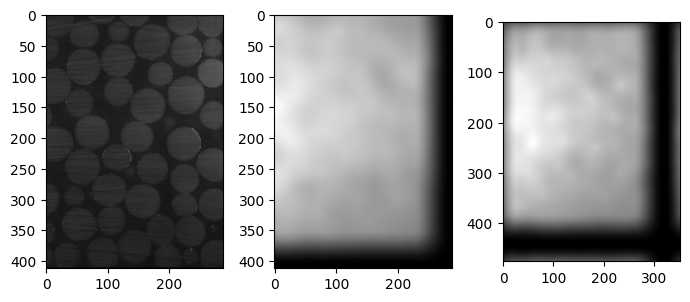

In [335]:
idx = 100
multiplot(dChunks[0][:,:,idx], dConv[0][:,:,idx], convMaps[0][:,:,idx],ax_vis=True)

In [354]:
dPad = int(kernel.shape[0]/2)
r,c,z = pchunks[0].shape

if cuts == 1:
    dChunks = [convMaps[0][:,:,:z-dPad], convMaps[1][:,:,dPad:]]

elif cuts == 2:
    dChunks = [convMaps[0][:, :c-dPad, :z-dPad], convMaps[1][:, dPad:, :z-dPad],
               convMaps[2][:, :c-dPad:, dPad:],   convMaps[3][:, dPad:, dPad:]]

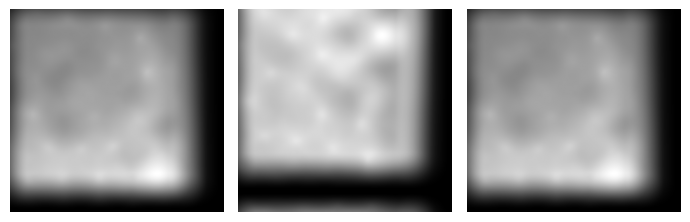

In [386]:
if cuts == 1:
    dog = np.concatenate((dChunks[0],dChunks[1]),axis=1)
elif cuts == 2:
    dog = np.concatenate((dChunks[0],dChunks[1]),axis=0)

idx=3
multiplot(dChunks[0][idx,:,:],dChunks[1][idx,:,:],dog[idx,:,:])


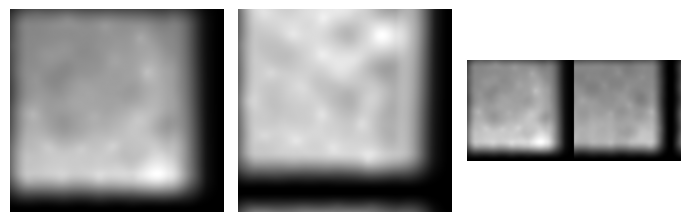

In [ ]:
idx = 3

In [336]:
arr1 = np.array([[1,2,3],
                 [1,2,3],
                 [1,2,3]])
arr2 = np.array([[4,5,6],
                 [4,5,6],
                 [4,5,6]])

In [339]:
np.concatenate((arr1,arr2),axis=1)

array([[1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6]])

In [ ]:
if cuts == 1:
    dChunks = [convMaps[0][:,:,int(z/2):z], convMaps[1][:,:,0:int(z/2)]]
    
elif cuts == 2:
    dChunks = [convMaps[0][:,int(c/2):c,int(z/2):z], convMaps[1][:,0:int(c/2),int(z/2):z],
               convMaps[2][:,int(c/2):c,0:int(z/2)], convMaps[3][:,0:int(c/2),0:int(z/2)]]

In [272]:
meow = np.array([[1,2,3],
                 [4,5,6],
                 [7,8,9]])
dog = np.array([[1,2],
                [4,5]])
print(dog.shape)
print(meow[:2,:2])
print(meow[:dog.shape])


(2, 2)
[[1 2]
 [4 5]]


TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
norChunks = [chunk[] for idx,chunk in enumerate(pchunks)]

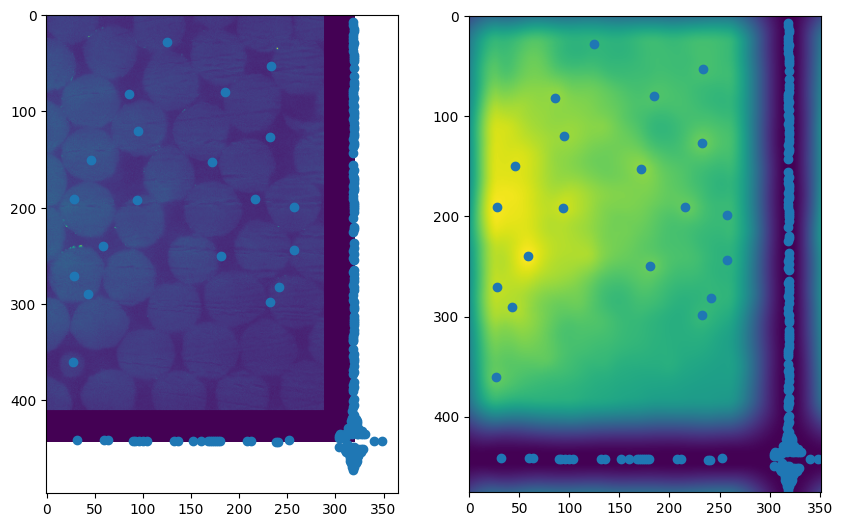

In [251]:
cimg = pchunks[0]
cimap = convMaps[0]

idx = 100
img = cimg[:,:,idx]
imap = cimap[:,:,idx]
peaks = peak_local_max(imap.numpy())

fig,axs = plt.subplots(1,2)
axs[0].imshow(img[32:,32:])
axs[1].imshow(imap)

axs[0].scatter(peaks[:,1],peaks[:,0])
axs[1].scatter(peaks[:,1],peaks[:,0])
fig.set_size_inches(10,7)

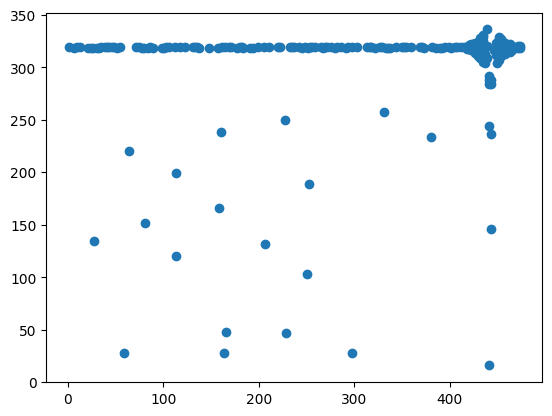

In [ ]:

plt.scatter(peaks[:,0],peaks[:,1]);

4
[torch.Size([476, 352, 369]), torch.Size([476, 352, 369]), torch.Size([476, 352, 369]), torch.Size([476, 352, 369])]
[torch.Size([476, 352, 369]), torch.Size([476, 352, 369]), torch.Size([476, 352, 369]), torch.Size([476, 352, 369])]


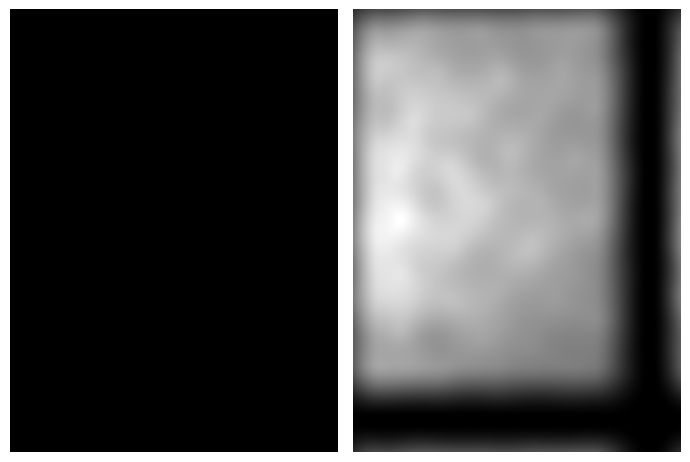

In [ ]:
print(len(convMaps))
print([obj.shape for obj in pchunks])
print([obj.size() for obj in convMaps])


In [ ]:
    nuData = torch.from_numpy(data)
    nuKern = torch.from_numpy(kernel)
    
    gpuData = nuData.to('cuda')
    gpuKern = nuKern.to('cuda')

In [ ]:
# FFT assumes cyclical boundary conditions, gotta pad the chunks and kernel or something
gpuKern =  torch.from_numpy(kernel).cuda()
frenchKern  = fft.rfft(gpuKern)

convChunks = []
for chunk in chunks:
    gpuChunk = torch.from_numpy(chunk).cuda() 
    frenchChunk = fft.rfft(gpuChunk)
    del gpuChunk

    frenchChunk *= frenchKern
    convolvedChunk = frenchChunk.cpu().numpy()
    convChunks.append(convolvedChunk)
    del frenchChunk

RuntimeError: The size of tensor a (153) must match the size of tensor b (33) at non-singleton dimension 2

In [ ]:
# !!! CLAUDES INTERPRETATION ON HOW TO SOLVE THIS, need to pad kernel and data, and inverse the fft!!!

import torch.fft as fft
import torch.nn.functional as F

# Prepare kernel
gpuKern = torch.from_numpy(kernel).float().cuda()

convChunks = []
for chunk in chunks:
    gpuChunk = torch.from_numpy(chunk).float().cuda()
    
    # Zero-pad both to size (chunk_size + kernel_size - 1)
    pad_size = tuple((k//2, k//2) for k in kernel.shape[::-1])  # Padding for each dim
    gpuChunk_padded = F.pad(gpuChunk, [p for pair in pad_size for p in pair])
    
    # 3D FFT
    frenchChunk = fft.rfftn(gpuChunk_padded)
    del gpuChunk, gpuChunk_padded
    
    # Kernel FFT (must match padded chunk size!)
    frenchKern = fft.rfftn(gpuKern, s=frenchChunk.shape)
    
    # Multiply in frequency domain
    frenchChunk *= frenchKern
    del frenchKern
    
    # INVERSE FFT to get back to spatial domain
    convolvedChunk = fft.irfftn(frenchChunk)
    del frenchChunk
    
    # Crop padding to get valid region
    # ... cropping logic here ...
    
    convChunks.append(convolvedChunk.cpu().numpy())

In [8]:
a,b,c = legData.shape
cat = legData[0:int(a/2),0:int(b/1.5),0:int(c/2)]
dataSizes(globals().items())

,Mb,Gb
legData,20884,20.4
cat,3481,3.4
data,220,0.2
kernel,2,0.0
core,0,0.0
particle,0,0.0


In [9]:
if torch.cuda.is_available():
    print(f"Available: {torch.cuda.get_device_name(0)}")
    nuLega = torch.from_numpy(legData)
    nuData = torch.from_numpy(data)
    nuKern = torch.from_numpy(kernel)

    gpuLega = nuLega.to('cuda')
    gpuData = nuData.to('cuda')
    gpuKern = nuKern.to('cuda')
    print(f"Data Loc:  {gpuData.device}")
else:
    print("No GPU available")

Available: NVIDIA RTX A2000 12GB
Data Loc:  cuda:0


In [10]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  21106 MiB |  21326 MiB |  21328 MiB | 227426 KiB |
|       from large pool |  21106 MiB |  21326 MiB |  21328 MiB | 227426 KiB |
|       from small pool |      0 MiB |      0 MiB |      0 MiB |      0 KiB |
|---------------------------------------------------------------------------|
| Active memory         |  21106 MiB |  21326 MiB |  21328 MiB | 227426 KiB |
|       from large pool |  21106 MiB |  21326 MiB |  21328 MiB |

In [11]:
print(legData.shape,type(legData[10,2,1]))
print(np.round(legData.nbytes/(1024**3),2),'Gb')


(2184, 2448, 2048) <class 'numpy.uint16'>
20.4 Gb


In [12]:
# Start recording memory snapshot history
torch.cuda.memory._record_memory_history(max_entries=100000)

fKern = fft.rfft(gpuKern, norm='forward')
fData = fft.rfft(gpuData, norm='forward')

# Dump memory snapshot history to a file and stop recording
torch.cuda.memory._dump_snapshot("profile.pkl")
torch.cuda.memory._record_memory_history(enabled=None)

In [13]:
fKern = fft.rfft(gpuKern, norm='forward')
fData = fft.rfft(gpuData, norm='forward')
fLega = fft.rfft(gpuLega, norm='forward')

OutOfMemoryError: CUDA out of memory. Tried to allocate 40.83 GiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 61.84 GiB is allocated by PyTorch, and 18.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])
torch.Size([64, 33])
torch.Size([64, 33])


ValueError: x and y must be the same size

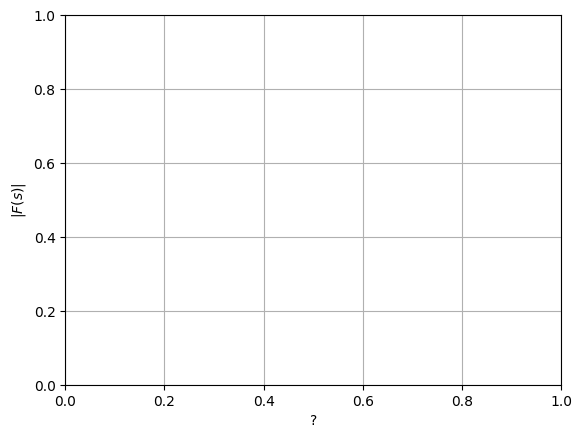

In [ ]:
fourier = fourier.cpu()
absolutes = torch.abs(fourier)

print(torch.arange(absolutes.shape[0]))
print(fourier.shape)
print(absolutes.shape)

fig, ax = plt.subplots()
ax.set_xlabel('?')
ax.set_ylabel('$|F(s)|$')
ax.grid()
ax.scatter(x=torch.arange(absolutes.shape[0]), y=absolutes, s=8)

In [ ]:
print(fourier.shape,lay.shape)

torch.Size([64, 33]) torch.Size([64, 64])


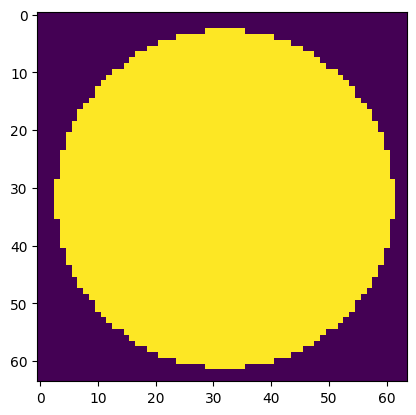

In [ ]:
x = torch.rand(5, 3)
print(x)

tensor([[0.4298, 0.5493, 0.5596],
        [0.1986, 0.6548, 0.3524],
        [0.3335, 0.9568, 0.6567],
        [0.3206, 0.5727, 0.2256],
        [0.2307, 0.3356, 0.6051]])


In [ ]:
torData = torch.from_numpy(data)
print(torData.device)

cpu


In [ ]:
dog = torData.to('cuda')
print(torData.device)
print(dog.device)

cpu
cuda:0


In [ ]:
tensor = np.array([1,2])
if torch.accelerator.is_available():
    tensor = tensor.to(torch.accelerator.current_accelerator())

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [ ]:
raise MemoryError
chiMap = fftconvolve(cat,kernel,mode='same')
invChi = 1/(chiMap+1e-12)

KeyboardInterrupt: 

In [ ]:
chiMap = fftconvolve(data,kernel,mode='full')
invChi = 1/(chiMap+1e-12)

In [ ]:
coords = peak_local_max(data, min_distance=int(MinSep), threshold_abs=CutOff)

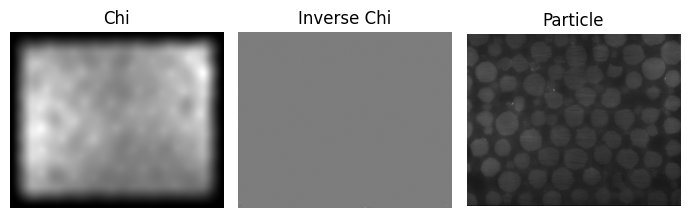

In [ ]:
multiplot(chiMap[:,:,50],50*invChi[:,:,50],data[:,:,50],titles=['Chi','Inverse Chi', 'Particle'])

In [ ]:
chi3D, _ = chiimg3D_FFT(dataRescale, ipi)
Np, px, py, pz = findpeaks3D(1./(chi3D+1e-12), Cutoff=Cutoff, MinSep=MinSep)

In [ ]:
def convolution3D_FFTdomain(img, kernel): 
    return fftconvolve(img, kernel, mode='same')

def chiimg3D_FFT(img, ip, W=None, Wip2=None):
    if W is None: 
        W = ip
    if Wip2 is None: 
        Wip2 = convolution3D_FFTdomain(np.ones_like(img), ip**2 * W)
    return 1 + (-2*convolution3D_FFTdomain(img, ip*W) + convolution3D_FFTdomain(img**2, W))/Wip2, Wip2



def findpeaks3D(img, CutOff=0, MinSep=1):
    coords = peak_local_max(img, min_distance=int(MinSep), threshold_abs=CutOff)
    spx, spy, spz = coords[:, 2], coords[:, 1], coords[:, 0]  # XYZ
    return len(spx), spx, spy, spz
